Using device: cpu
TinyImageNet already available.
Total TinyImageNet train samples: 100000
Selected class indices: [112, 31, 21, 191, 143, 107, 14, 40, 175, 170]
Training samples: 4000 | Test samples: 1000 | Classes: 10


Baseline Epoch 1/3: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Loss: 2.2951


Baseline Epoch 2/3: 100%|██████████| 63/63 [00:15<00:00,  4.10it/s]


Loss: 2.2396


Baseline Epoch 3/3: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]


Loss: 2.1969
Baseline training done.

Epoch 1/3 Loss: 2.3039
Epoch 2/3 Loss: 2.3019
Epoch 3/3 Loss: 2.3026
NUI-Augmented robust training complete.

Baseline Model:
  Clean Test Accuracy: 18.70%
  NUI Test Accuracy:   18.90%
  Accuracy Drop:       -0.20%

Robust Model (NUI-Augmented Training):
  Clean Test Accuracy: 10.90%
  NUI Test Accuracy:   10.90%
  Accuracy Increase on NUI: -8.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


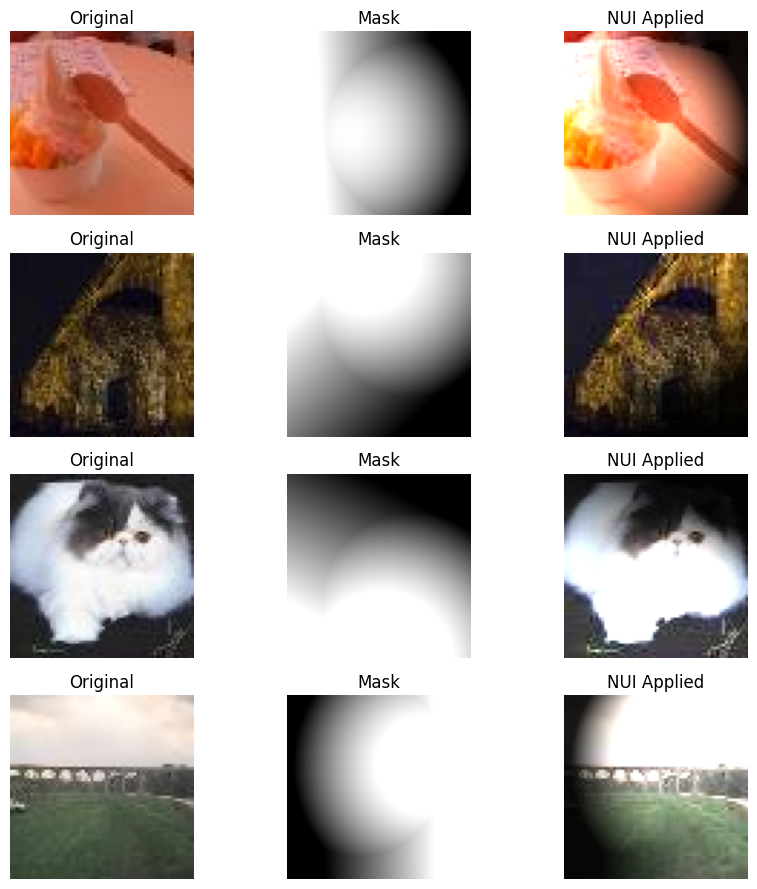

In [6]:
# ==============================================
# 1 Setup
# ==============================================
import os, random, zipfile, urllib.request
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (10, 5)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# ==============================================
# 2 Download TinyImageNet Subset (if not present)
# ==============================================
data_root = "./TinyImageNet"
zip_path = os.path.join(data_root, "tiny-imagenet-200.zip")
extract_path = os.path.join(data_root, "tiny-imagenet-200")

if not os.path.exists(extract_path):
    os.makedirs(data_root, exist_ok=True)
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    print("Downloading TinyImageNet (~250MB)...")
    urllib.request.urlretrieve(url, zip_path)
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_root)
    print("Done.")
else:
    print("TinyImageNet already available.")

# ==============================================
# 3 Strong NUI Mask Functions
# ==============================================
def generate_strong_nui_mask(h, w, strength=1.0, exponent=2.0):
    yy, xx = np.meshgrid(np.linspace(-1, 1, h), np.linspace(-1, 1, w), indexing='ij')
    angle = np.random.uniform(0, 2*np.pi)
    direction = np.cos(angle)*xx + np.sin(angle)*yy
    cx, cy = np.random.uniform(-0.5, 0.5, 2)
    r = np.sqrt((xx - cx)**2 + (yy - cy)**2)
    radial = 1 - np.clip(r, 0, 1)**exponent
    mask = 0.6*direction + 0.4*radial
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = 1 + strength * (mask - 0.5)
    mask = np.clip(mask, 0.1, 1.9).astype(np.float32)
    return mask

def apply_mask_to_tensor(img_tensor, mask):
    mask_tensor = torch.tensor(mask).unsqueeze(0).to(img_tensor.device)
    if mask_tensor.dim() == 3:
        mask_tensor = mask_tensor.unsqueeze(0)
    mask_tensor = F.interpolate(mask_tensor, size=img_tensor.shape[1:], mode='bilinear', align_corners=False).squeeze(0)
    return img_tensor * mask_tensor

def apply_nui_to_img(img_tensor):
    h, w = img_tensor.shape[1], img_tensor.shape[2]
    mask = generate_strong_nui_mask(h, w)
    return apply_mask_to_tensor(img_tensor, mask)

# ==============================================
# 4 Load TinyImageNet Subset (10 Classes)
# ==============================================
transform = T.Compose([T.Resize((64, 64)), T.ToTensor()])

dataset_path = os.path.join(extract_path, "train")
full_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
print("Total TinyImageNet train samples:", len(full_dataset))

# Pick 10 random classes
class_indices = random.sample(range(200), 10)
print("Selected class indices:", class_indices)

# Build label mapping (old -> new)
label_map = {old: new for new, old in enumerate(class_indices)}

# Filter dataset for only these classes
subset_samples = [(path, label_map[label]) for path, label in full_dataset.samples if label in class_indices]

# Replace samples and targets
full_dataset.samples = subset_samples
full_dataset.targets = [label for _, label in subset_samples]

# Take subset of 10000 images
subset_idx = list(range(min(10000, len(full_dataset.samples))))
dataset = Subset(full_dataset, subset_idx)

train_size = int(0.80 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

num_classes = len(class_indices)
print(f"Training samples: {len(trainset)} | Test samples: {len(testset)} | Classes: {num_classes}")

# ==============================================
# 5 Tiny CNN Model (SqueezeNet)
# ==============================================
import torchvision.models as models

class SqueezeNetCustom(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = models.squeezenet1_1(pretrained=False)
        self.model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        self.model.num_classes = num_classes

    def forward(self, x):
        return self.model(x)

# ==============================================
# 6 Evaluation Function
# ==============================================
def testing(model, loader, apply_nui=False):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            if apply_nui:
                perturbed = [apply_nui_to_img(img) for img in imgs]
                imgs = torch.stack(perturbed)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return correct / total

# ==============================================
# 7 Baseline Training (Clean Images)
# ==============================================
model_clean = SqueezeNetCustom(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_clean.parameters(), lr=0.001)

epochs = 3
for epoch in range(epochs):
    model_clean.train()
    running_loss = 0.0
    for imgs, labels in tqdm(trainloader, desc=f"Baseline Epoch {epoch+1}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_clean(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Loss: {running_loss/len(trainloader):.4f}")
print("Baseline training done.\n")

# ==============================================
# 10 NUI-Augmented (Robust) Training
# ==============================================
def train_model_mixed(model, trainloader, optimizer, criterion, epochs, nui_ratio=0.80):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, labels in trainloader:
            imgs, labels = imgs.to(device), labels.to(device)
            mask = torch.rand(len(imgs)) < nui_ratio
            imgs_aug = [apply_nui_to_img(img) if mask[i] else img for i, img in enumerate(imgs)]
            imgs_aug = torch.stack(imgs_aug)
            optimizer.zero_grad()
            outputs = model(imgs_aug)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {running_loss/len(trainloader):.4f}")

# Train robust model
model_nui = SqueezeNetCustom(num_classes=num_classes).to(device)
optimizer = optim.Adam(model_nui.parameters(), lr=0.001)
train_model_mixed(model_nui, trainloader, optimizer, criterion, epochs, nui_ratio=0.8)
print("NUI-Augmented robust training complete.\n")

# ==============================================
# 9 Evaluate Models
# ==============================================
acc_clean     = testing(model_clean, testloader, apply_nui=False)
acc_nui       = testing(model_clean, testloader, apply_nui=True)
acc_clean_aug = testing(model_nui, testloader, apply_nui=False)
acc_nui_aug   = testing(model_nui, testloader, apply_nui=True)

# Convert to percentage
acc_clean_pct     = acc_clean * 100
acc_nui_pct       = acc_nui * 100
acc_clean_aug_pct = acc_clean_aug * 100
acc_nui_aug_pct   = acc_nui_aug * 100

# Baseline model (trained on clean data)
acc_clean_drop = acc_clean_pct - acc_nui_pct
print(f"Baseline Model:")
print(f"  Clean Test Accuracy: {acc_clean_pct:.2f}%")
print(f"  NUI Test Accuracy:   {acc_nui_pct:.2f}%")
print(f"  Accuracy Drop:       {acc_clean_drop:.2f}%\n")

# Robust model (trained on NUI-augmented data)
acc_nui_increase = acc_nui_aug_pct - acc_nui_pct
robust_drop = acc_clean_aug_pct - acc_nui_aug_pct

print(f"Robust Model (NUI-Augmented Training):")
print(f"  Clean Test Accuracy: {acc_clean_aug_pct:.2f}%")
print(f"  NUI Test Accuracy:   {acc_nui_aug_pct:.2f}%")
print(f"  Accuracy Increase on NUI: {acc_nui_increase:.2f}%")

# ==============================================
# 10 Visualize NUI Effect
# ==============================================
def visualize_nui_effect(num_images=4):
    imgs, _ = next(iter(testloader))
    fig, axes = plt.subplots(num_images, 3, figsize=(9, 9))
    for i in range(num_images):
        img = imgs[i]
        mask = generate_strong_nui_mask(64, 64, strength=3.0, exponent=2.0)
        img_nui = apply_mask_to_tensor(img, mask)
        axes[i,0].imshow(img.permute(1,2,0)); axes[i,0].set_title("Original"); axes[i,0].axis("off")
        axes[i,1].imshow(mask, cmap="gray"); axes[i,1].set_title("Mask"); axes[i,1].axis("off")
        axes[i,2].imshow(img_nui.permute(1,2,0)); axes[i,2].set_title("NUI Applied"); axes[i,2].axis("off")
    plt.tight_layout()
    plt.show()

visualize_nui_effect()
